In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import googlenet
from torchvision import datasets

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm
import time
import torch.nn.functional as F

## **Setting Device and Loading the Dataset** 

In [18]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_path = '../data_cifar/'

# Define transformations for the dataset
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),            # Random horizontal flip
    transforms.RandomRotation(10),                # Random rotation (degrees)
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),               # Random rotation (degrees)
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(data_path, train=True, 
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, 
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(data_path, train=False, 
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, 
                                         shuffle=False)

cuda
Files already downloaded and verified
Files already downloaded and verified


## **Loading and Modifying the GoogleNet Model**

In [19]:
# Load pretrained GoogleNet model
net = googlenet(pretrained=True)
num_classes = 10
net

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [20]:
# Load pretrained GoogleNet model
net = googlenet(pretrained=True)
num_classes = 10

for param in net.parameters():
    param.requires_grad = False
    
for param in net.inception4b.parameters():
    param.requires_grad = True
    
# Modify the last layers of the GoogleNet model
net.fc = nn.Sequential(nn.Linear(1024, 512),
                       nn.ReLU(),
                       nn.Linear(512,10))

# Move model to device
net = net.to(device)

In [21]:
net

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [22]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [23]:
model_out_path = "model.pth"
torch.save(net, model_out_path)
print("Checkpoint saved to {}".format(model_out_path))

Checkpoint saved to model.pth


## **Training and testing the model**

In [24]:
epochs = 10
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

train_stats = {
    'epoch': [],
    'loss': [],
    'acc': []
}
test_stats = {
    'epoch': [],
    'loss': [],
    'acc': []
}
pbar = tqdm(range(epochs))
start_time = time.time()
for epoch in (pbar):

    pbar.set_description(f"Epoch {epoch + 1} / 10")
    net.train()
    for batch_idx, (features, targets) in enumerate(trainloader):

        features = features.to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        logits = net(features)
        cost = F.cross_entropy(logits, targets)
        acc = accuracy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        train_stats['epoch'].append(epoch + batch_idx / len(trainloader))
        train_stats['loss'].append(cost.item())
        train_stats['acc'].append(acc.item())
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f | Accuracy: %.4f |' 
                   %(epoch+1, epochs, batch_idx,
                     len(trainloader), cost, acc))

    test_loss = compute_epoch_loss(net, testloader)
    test_acc = compute_accuracy(net, testloader)
    test_stats['epoch'].append(epoch + 1)
    test_stats['loss'].append(test_loss)
    test_stats['acc'].append(test_acc)
    print ('Epoch: ', epoch+1, ' Loss = ', test_loss, ' Accuracy = ', test_acc)

    net.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Loss: %.3f' % (
              epoch+1, epochs,
              compute_accuracy(net, trainloader),
              compute_epoch_loss(net, trainloader)))


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 001/010 | Batch 0000/0782 | Cost: 2.2837 | Accuracy: 0.1094 |
Epoch: 001/010 | Batch 0050/0782 | Cost: 2.2602 | Accuracy: 0.1875 |
Epoch: 001/010 | Batch 0100/0782 | Cost: 2.2065 | Accuracy: 0.2969 |
Epoch: 001/010 | Batch 0150/0782 | Cost: 2.1304 | Accuracy: 0.5156 |
Epoch: 001/010 | Batch 0200/0782 | Cost: 2.0750 | Accuracy: 0.4531 |
Epoch: 001/010 | Batch 0250/0782 | Cost: 1.9962 | Accuracy: 0.5312 |
Epoch: 001/010 | Batch 0300/0782 | Cost: 1.8292 | Accuracy: 0.5156 |
Epoch: 001/010 | Batch 0350/0782 | Cost: 1.6801 | Accuracy: 0.6094 |
Epoch: 001/010 | Batch 0400/0782 | Cost: 1.4989 | Accuracy: 0.6250 |
Epoch: 001/010 | Batch 0450/0782 | Cost: 1.3859 | Accuracy: 0.7500 |
Epoch: 001/010 | Batch 0500/0782 | Cost: 1.4150 | Accuracy: 0.5469 |
Epoch: 001/010 | Batch 0550/0782 | Cost: 1.1095 | Accuracy: 0.7188 |
Epoch: 001/010 | Batch 0600/0782 | Cost: 1.1047 | Accuracy: 0.7188 |
Epoch: 001/010 | Batch 0650/0782 | Cost: 1.0463 | Accuracy: 0.6719 |
Epoch: 001/010 | Batch 0700/0782 |

## **Results and Analysis**

In [25]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(net, testloader)))

Test accuracy: 91.57%


In [26]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for batch_idx, (features, targets) in enumerate(testloader):

    features = features
    targets = targets
    break

logits = net(features.to(device))
_, predicted_labels = torch.max(logits, 1)



In [27]:
model_out_path = "model.pth"
torch.save(net, model_out_path)
print("Checkpoint saved to {}".format(model_out_path))

Checkpoint saved to model.pth


In [28]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

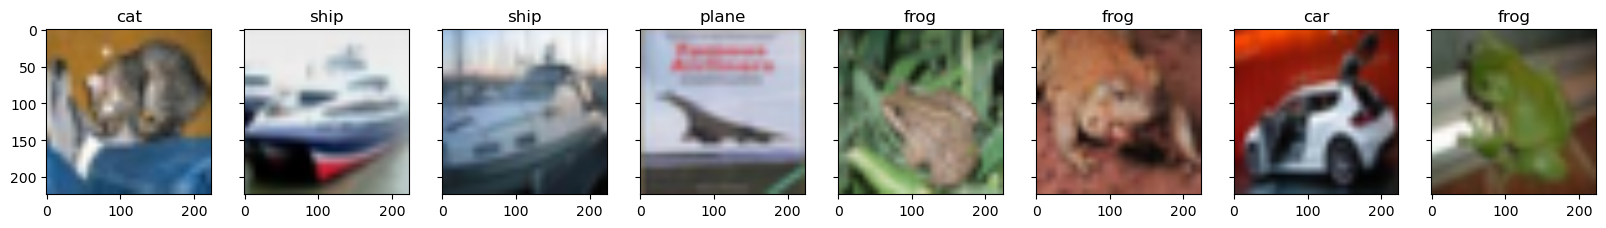

In [29]:
n_images = 8

fig, axes = plt.subplots(nrows=1, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]

for i in range(n_images):
    curr_img = orig_images[i].detach().to(torch.device('cpu'))
    curr_img = unnormalize(curr_img,
                           torch.tensor([0.485, 0.456, 0.406]),
                           torch.tensor([0.229, 0.224, 0.225])) 
    curr_img = curr_img.permute((1, 2, 0))
    axes[i].imshow(curr_img)
    axes[i].set_title(classes[predicted_labels[i]])

### Confusion Matrix

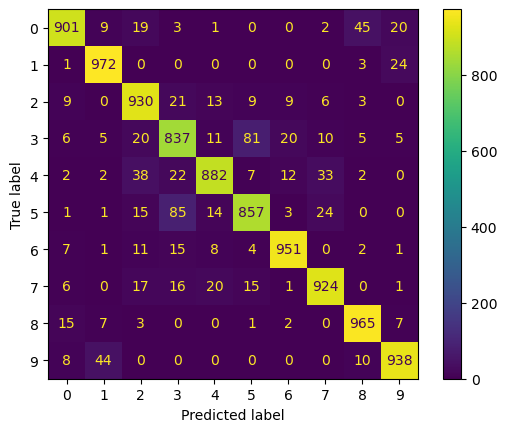

In [30]:
y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():

  for inputs, labels in testloader:
          inputs = inputs.to(device)
          labels = labels.to(device)
        #   inputs = inputs.reshape(inputs.shape[0], -1)

          output = net(inputs)

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth


cm = confusion_matrix(y_true,y_pred)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.show()

### Classification Report

In [31]:
#Model accuracy
report = classification_report(y_true,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1000
           1       0.93      0.97      0.95      1000
           2       0.88      0.93      0.91      1000
           3       0.84      0.84      0.84      1000
           4       0.93      0.88      0.91      1000
           5       0.88      0.86      0.87      1000
           6       0.95      0.95      0.95      1000
           7       0.92      0.92      0.92      1000
           8       0.93      0.96      0.95      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Consequently, GoogleNet provided the highest accuracy among all models in the project with relatively moderate time performace (nearly 70 mins)